In [2]:
import torch
print("GPU: ",torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = "cpu"

print("Device -> ", device)

GPU:  True
Device ->  cuda:0


In [3]:
from google.colab import drive
drive.mount('content/drive/')

MessageError: ignored

In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def gen_net(
    input_size = 20,
    num_hidden_layers = 1,
    num_hidden_units = 100,
    num_output_units=784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size,num_hidden_units))
    model.add_module(f'relu_g{i}',nn.LeakyReLU())
    input_size=num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size,num_output_units))
  model.add_module('tanh_g', nn.Tanh())
  return model

In [5]:
def disc_net(
    input_size,
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units = 1):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(
        f'fc_d{i}',
        nn.Linear(input_size,num_hidden_units,bias=False)
    )
    model.add_module(f'relu_d{i}',nn.LeakyReLU())
    model.add_module('dropout', nn.Dropout(p=0.5))
    input_size = num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size,num_output_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model

In [6]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)
gen_model = gen_net(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
)
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [7]:
disc_model = disc_net(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size
)
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5),std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path,train=True,
    transform=transform,download=True
)
example,label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 140670440.07it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115038645.61it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 33008893.82it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6510775.38it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [9]:
def noising(batch_size,z_size,mode_z):
  ## here we create a random vector based on a random distribution
  if mode_z == "uniform":
    input_z = torch.rand(batch_size, z_size)*2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [10]:
from torch.utils.data import DataLoader
batch_size = 32
dataloader = DataLoader(mnist_dataset,batch_size,shuffle=False)
input_real , label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'uniform' # uniform or normal
input_z = noising(batch_size,z_size,mode_z)
print('Noise input -- shape:', input_z.shape)
print('Real input -- shape: ', input_real.shape)

Noise input -- shape: torch.Size([32, 20])
Real input -- shape:  torch.Size([32, 784])


In [11]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: torch.Size([32, 784])


In [12]:
d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [13]:
loss_fn = nn.BCELoss()
## Generators Loss
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')
## Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6983
Discriminator Losses: Real 0.7479 Fake 0.6885


In [16]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
gen_model = gen_net(
    input_size=z_size,
    num_hidden_layers= gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units=np.prod(image_size)
).to(device)
disc_model = disc_net(
    input_size=np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units=disc_hidden_size
).to(device)

In [17]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [19]:
def disc_train(x):
  disc_model.zero_grad()
  ## real batch training
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)
  ## Fake batch training
  input_z = noising(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
  ## gradient backprop & only discriminators parameters optimizations
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_proba_real.detach(),d_proba_fake.detach()

def gen_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = noising(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size, 1, device=device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)
  ## gradient backprop & only Generators parameters optimizations
  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [21]:
fixed_z = noising(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100
for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = disc_train(x)
    d_losses.append(d_loss)
    g_losses.append(gen_train(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())
  print(f'Epoch {epoch:03d} | Avg Losses >>'
    f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
    f' [D-Real: {all_d_real[-1]:.4f}'
    f' D-Fake: {all_d_fake[-1]:.4f}]'
  )
  epoch_samples.append(
      create_samples(gen_model, fixed_z).detach().cpu().numpy()
  )

Epoch 001 | Avg Losses >> G/D 0.8980/0.8897 [D-Real: 0.8129 D-Fake: 0.4693]
Epoch 002 | Avg Losses >> G/D 0.8809/1.2171 [D-Real: 0.5805 D-Fake: 0.4555]
Epoch 003 | Avg Losses >> G/D 0.9189/1.1951 [D-Real: 0.5803 D-Fake: 0.4286]
Epoch 004 | Avg Losses >> G/D 0.9199/1.2074 [D-Real: 0.5764 D-Fake: 0.4245]
Epoch 005 | Avg Losses >> G/D 0.8665/1.2774 [D-Real: 0.5455 D-Fake: 0.4458]
Epoch 006 | Avg Losses >> G/D 0.9165/1.2550 [D-Real: 0.5568 D-Fake: 0.4387]
Epoch 007 | Avg Losses >> G/D 0.8829/1.2701 [D-Real: 0.5553 D-Fake: 0.4477]
Epoch 008 | Avg Losses >> G/D 0.9392/1.2239 [D-Real: 0.5697 D-Fake: 0.4271]
Epoch 009 | Avg Losses >> G/D 1.0444/1.1574 [D-Real: 0.6009 D-Fake: 0.4031]
Epoch 010 | Avg Losses >> G/D 1.0449/1.1624 [D-Real: 0.6007 D-Fake: 0.4032]
Epoch 011 | Avg Losses >> G/D 1.0403/1.1613 [D-Real: 0.6041 D-Fake: 0.4042]
Epoch 012 | Avg Losses >> G/D 1.0259/1.1607 [D-Real: 0.6025 D-Fake: 0.4029]
Epoch 013 | Avg Losses >> G/D 1.0392/1.1600 [D-Real: 0.6018 D-Fake: 0.3985]
Epoch 014 | 

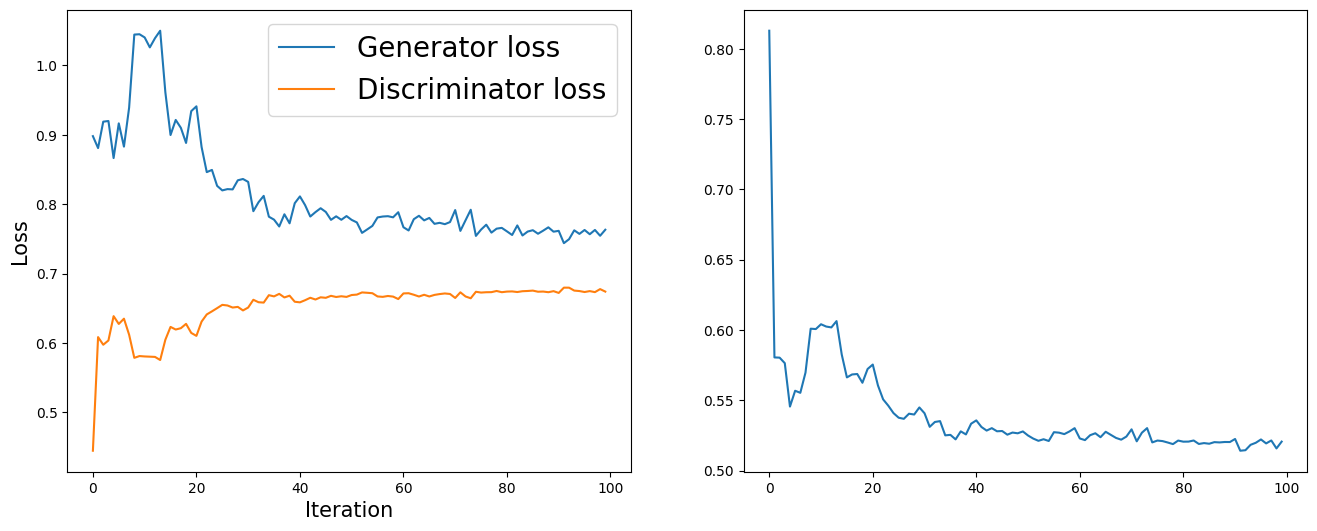

In [22]:
import itertools
fig = plt.figure(figsize=(16, 6))
# losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)
# outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

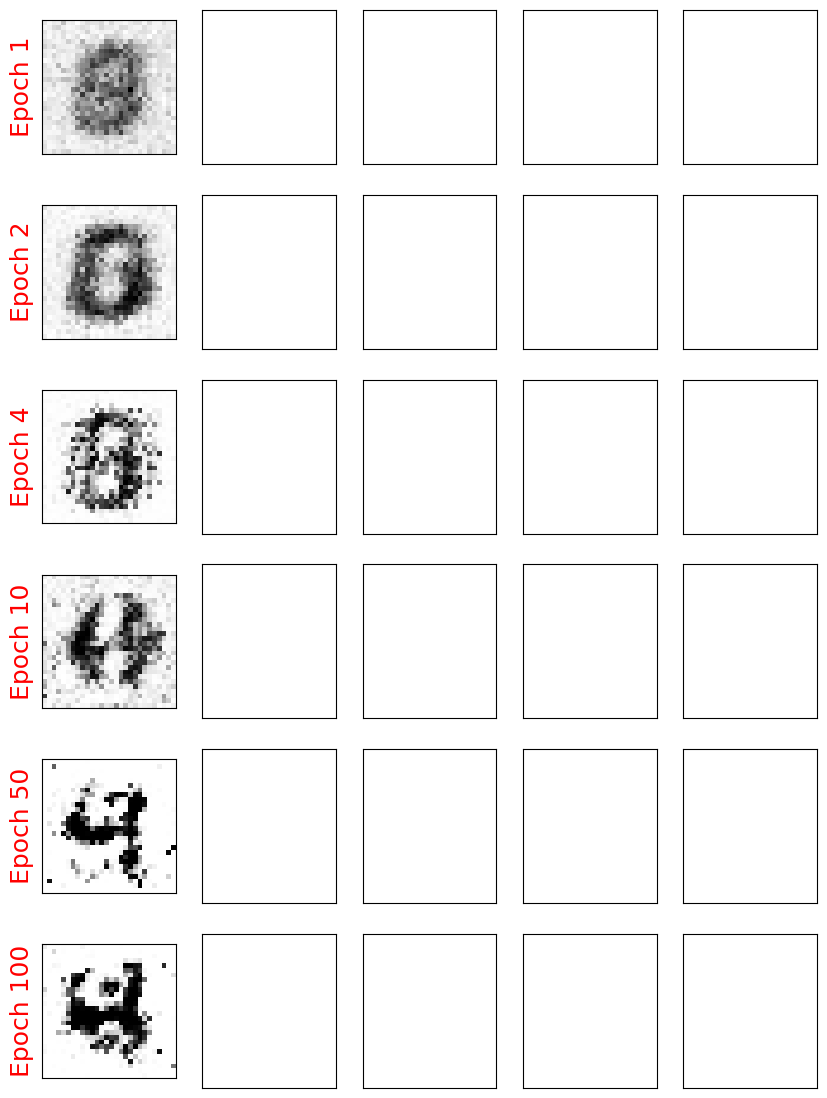

In [24]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoch {e}',
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes
      )
      image = epoch_samples[e-1][j]
      ax.imshow(image, cmap='gray_r')
plt.show()

In [15]:
np.prod(image_size)

784